In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s6e1/sample_submission.csv
/kaggle/input/playground-series-s6e1/train.csv
/kaggle/input/playground-series-s6e1/test.csv


In [16]:
import torch
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [17]:
CONFIG = {
    'batch_size': 32,
    'learning_rate': 1e-5,
    'epochs': 25,
    'val_split': 0.20,
    'random_seed': 42,
    'random_state': 42
}

# Data Paths
DATA_PATH = "/kaggle/input/playground-series-s6e1"
TRAIN_FILE = f"{DATA_PATH}/train.csv"
TEST_FILE = f"{DATA_PATH}/test.csv"

# Set random seeds for reproducibility
torch.manual_seed(CONFIG['random_seed'])
np.random.seed(CONFIG['random_seed'])

In [18]:
# Load training data
df_train = pd.read_csv(TRAIN_FILE)
print(f"Training data shape: {df_train.shape}")
print(f"\nColumns: {df_train.columns.tolist()}")
print(f"\nData types:\n{df_train.dtypes}")
print("\n")
df_train.head(10)

Training data shape: (630000, 13)

Columns: ['id', 'age', 'gender', 'course', 'study_hours', 'class_attendance', 'internet_access', 'sleep_hours', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty', 'exam_score']

Data types:
id                    int64
age                   int64
gender               object
course               object
study_hours         float64
class_attendance    float64
internet_access      object
sleep_hours         float64
sleep_quality        object
study_method         object
facility_rating      object
exam_difficulty      object
exam_score          float64
dtype: object




,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,0,21,female,b.sc,7.91,98.8,no,4.9,average,online videos,low,easy,78.3
1,1,18,other,diploma,4.95,94.8,yes,4.7,poor,self-study,medium,moderate,46.7
2,2,20,female,b.sc,4.68,92.6,yes,5.8,poor,coaching,high,moderate,99.0
3,3,19,male,b.sc,2.00,49.5,yes,8.3,average,group study,high,moderate,63.9
4,4,23,male,bca,7.65,86.9,yes,9.6,good,self-study,high,easy,100.0
5,5,24,male,b.com,5.04,85.1,yes,9.4,average,online videos,medium,moderate,70.1
6,6,20,male,b.sc,4.28,87.0,no,9.1,average,mixed,high,moderate,63.4
7,7,22,female,ba,4.19,44.9,yes,8.8,good,self-study,high,hard,76.8
8,8,22,other,b.com,1.06,98.3,yes,5.0,poor,mixed,low,moderate,46.7
9,9,18,male,bba,3.44,80.9,yes,6.2,good,group study,medium,easy,58.2


In [51]:
cols = [
    "sleep_quality",
    "facility_rating",
    "study_method",
    "exam_difficulty",
    "course",
    "gender"
]
print("Unique values :")
for col in cols:
    print(f"\n{col}:")
    print(df_train[col].unique())


Unique values :

sleep_quality:
[1 0 2]

facility_rating:
[0 1 2]

study_method:
['online videos' 'self-study' 'coaching' 'group study' 'mixed']

exam_difficulty:
[0 1 2]

course:
['b.sc' 'diploma' 'bca' 'b.com' 'ba' 'bba' 'b.tech']

gender:
['female' 'other' 'male']


In [20]:
def map_ordinals(df):
    # Ordinal mapping
    ordinal_mapping = {
        "sleep_quality": {"poor": 0, "average": 1, "good": 2},
        "facility_rating": {"low": 0, "medium": 1, "high": 2},
        "exam_difficulty": {"easy": 0, "moderate": 1, "hard": 2},
        "internet_access": {"yes" : 1 , "no" : 0},
    
        
    }

    # Optimized mapping
    for col, mapping in ordinal_mapping.items():
        df[col] = df[col].map(mapping)
    
    return df

train_df = map_ordinals(df_train)

In [21]:
def onehot(df):
    df = pd.get_dummies(df, columns=["gender", "course", "study_method"], dtype=int)
    return df

train_df = onehot(train_df)
train_df

,id,age,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,facility_rating,exam_difficulty,exam_score,...,course_b.tech,course_ba,course_bba,course_bca,course_diploma,study_method_coaching,study_method_group study,study_method_mixed,study_method_online videos,study_method_self-study
0,0,21,7.91,98.8,0,4.9,1,0,0,78.300,...,0,0,0,0,0,0,0,0,1,0
1,1,18,4.95,94.8,1,4.7,0,1,1,46.700,...,0,0,0,0,1,0,0,0,0,1
2,2,20,4.68,92.6,1,5.8,0,2,1,99.000,...,0,0,0,0,0,1,0,0,0,0
3,3,19,2.00,49.5,1,8.3,1,2,1,63.900,...,0,0,0,0,0,0,1,0,0,0
4,4,23,7.65,86.9,1,9.6,2,2,0,100.000,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629995,629995,18,4.86,70.7,1,4.1,2,2,1,69.500,...,1,0,0,0,0,0,0,1,0,0
629996,629996,21,7.08,54.4,1,4.5,1,0,1,78.900,...,0,1,0,0,0,0,0,1,0,0
629997,629997,24,0.64,44.2,1,4.3,0,0,1,19.599,...,0,0,0,1,0,0,0,0,1,0
629998,629998,20,1.54,75.1,1,8.2,1,2,1,59.100,...,0,0,0,0,0,0,1,0,0,0


In [22]:
X = train_df.drop(columns=["exam_score","id"])  # Drop target and maybe ID column 'd'
y = train_df["exam_score"]

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=CONFIG["val_split"],
    random_state=CONFIG["random_state"]
)

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit on training data only, transform both train and test
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

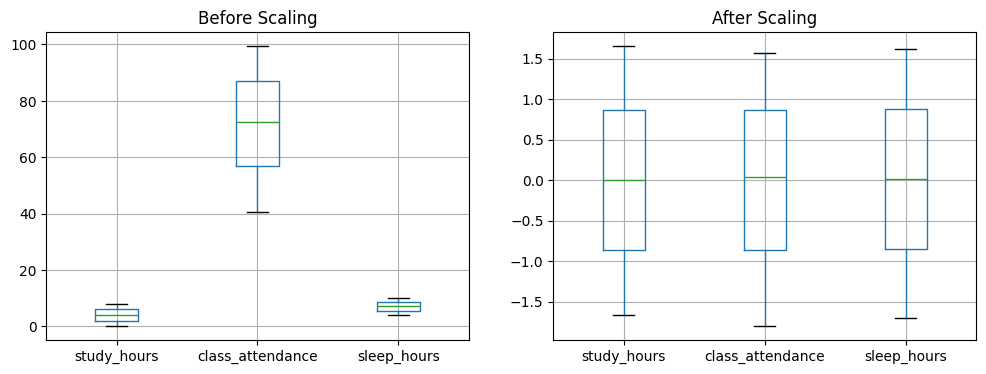

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Just pick a few numeric columns for visualization
numeric_cols = ["study_hours", "class_attendance", "sleep_hours"]

# Before scaling
X_before = train_df[numeric_cols]

# Initialize scaler and scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_before)

# Convert back to DataFrame for easy plotting
X_after = pd.DataFrame(X_scaled, columns=numeric_cols)

# Plot before and after scaling
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

X_before.boxplot(ax=axes[0])
axes[0].set_title("Before Scaling")

X_after.boxplot(ax=axes[1])
axes[1].set_title("After Scaling")

plt.show()


In [31]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Make sure all your features are numeric
X_train_np = np.array(X_train, dtype=np.float32)
X_val_np   = np.array(X_val, dtype=np.float32)
y_train_np = np.array(y_train, dtype=np.float32).reshape(-1, 1)
y_val_np   = np.array(y_val, dtype=np.float32).reshape(-1, 1)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_np)
y_train_tensor = torch.tensor(y_train_np)

X_val_tensor = torch.tensor(X_val_np)
y_val_tensor = torch.tensor(y_val_np)

# Create Datasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=4096, shuffle=True, num_workers=8, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=4096, num_workers=4, pin_memory=True)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [32]:
import pytorch_lightning as pl

# PyTorch Lightning Model
class LitExamNN(pl.LightningModule):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
        
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
        
            nn.Linear(128, 64),
            nn.ReLU(),
        
            nn.Linear(64, 1)
        )
    
        self.criterion = nn.MSELoss()
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self(X)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self(X)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.001, weight_decay=1e-5)

In [33]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor="val_loss", patience=10, mode="min")
checkpoint = ModelCheckpoint(
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    filename="best_exam_model"
)

In [34]:
import torch.nn as nn
import torch.optim as optim  # <- make sure this is here

model = LitExamNN(input_dim=X_train_tensor.shape[1])

trainer = pl.Trainer(
    max_epochs=100,
    callbacks=[early_stop, checkpoint],
    accelerator="gpu",
    devices=1,
    precision=16,  # mixed precision
    accumulate_grad_batches=1  # optional if batch too big
)


Using 16bit Automatic Mixed Precision (AMP)
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores


In [35]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/model_summary/model_summary.py:242: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type       ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ Sequential │ 47.4 K │ train │     0 │
│ 1 │ criterion │ MSELoss    │      0 │ train │     0 │
└───┴───────────┴────────────┴────────┴───────┴───────┘

Trainable params: 47.4 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 47.4 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 11                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

In [46]:
df_test = pd.read_csv(TEST_FILE)
df_test.head()

,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty
0,630000,24,other,ba,6.85,65.2,yes,5.2,poor,group study,high,easy
1,630001,18,male,diploma,6.61,45.0,no,9.3,poor,coaching,low,easy
2,630002,24,female,b.tech,6.60,98.5,yes,6.2,good,group study,medium,moderate
3,630003,24,male,diploma,3.03,66.3,yes,5.7,average,mixed,medium,moderate
4,630004,20,female,b.tech,2.03,42.4,yes,9.2,average,coaching,low,moderate


In [50]:
# 1️⃣ Read test data
df_test = pd.read_csv(TEST_FILE)

# 2️⃣ Apply same preprocessing as training
df_test = map_ordinals(df_test)   # ordinal columns
df_test = onehot(df_test)         # categorical columns

# 3️⃣ Save ID for submission
submission_ids = df_test["id"].copy()

# 4️⃣ Drop ID for prediction
X_test = df_test.drop(columns=["id"])

# 5️⃣ Reorder columns to match training
X_test = X_test  # ensure same order & columns as training

# 6️⃣ Convert to tensor
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to("cpu")

# 7️⃣ Predict
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).cpu().numpy()

# 8️⃣ Create submission CSV
submission = pd.DataFrame({
    "id": submission_ids,
    "exam_score": y_pred.flatten()
})
submission.to_csv("submissions.csv", index=False)
print(submission.head())


       id   exam_score
0  630000   749.350647
1  630001   576.054199
2  630002  1040.297974
3  630003   693.131348
4  630004   480.317230
